In [1]:
# %pip install librosa
# %pip install scikit-learn
# %pip install soundfile


In [2]:
import pathlib
import warnings
import subprocess
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
import joblib
from sklearn.pipeline import make_pipeline

warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# DataFrame global para armazenar todas as músicas processadas
df_master_songs = pd.DataFrame()

In [4]:
def cleasing(song):
    # Fazer tratamento para se o nome da música já tiver no Bucket
    song = pathlib.Path(song)
    song_name = song.stem
    if song.suffix != '.wav':
        subprocess.call(['ffmpeg', '-i', str(song), f'{song_name}.wav'])
    return song

In [5]:
def stft(song, number):
    global df_master_songs
    y, sr = librosa.load(song, sr=None, mono=True)
    
    S = librosa.stft(y, n_fft=2048, hop_length=512, win_length=1024)
    S = np.abs(S)

    max_indices = np.argwhere(S == np.max(S, axis=0))
    times = librosa.frames_to_time(max_indices[:, 1], sr=sr)
    frequencies = librosa.fft_frequencies(sr=sr)[max_indices[:, 0]]
    
    # Criação do DataFrame da música atual
    df_song = pd.DataFrame({'Frequencia': frequencies, 'Tempo': times})
    
    # Atribuir o valor de target para todas as linhas
    df_song['target'] = number
    
    # Concatenando no DataFrame global
    df_master_songs = pd.concat([df_master_songs, df_song], ignore_index=True)

    return df_master_songs

In [6]:
def training_model(data):
    # Remover a coluna 'target' do conjunto de features
    target = data.pop('target')
    X = data
    y = target

    # Divisão entre treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Ajustar o scaler com os dados de treino
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)  # Ajustar e transformar os dados de treino
    X_test_n = scaler.transform(X_test)        # Transformar os dados de teste

    # Redução de dimensionalidade usando PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_n)
    X_test_pca = pca.transform(X_test_n)

    # Converte as variáveis de target para inteiros
    y_train_int = y_train.astype(int)
    y_test_int = y_test.astype(int)

    # KNN    
    k_values = list(range(2, 15))
    metrics = []

    # Loop para encontrar o melhor valor de k
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_pca, y_train_int)
        
        y_test_int_pred = knn.predict(X_test_pca)
        test_accuracy = accuracy_score(y_test_int, y_test_int_pred)
        metrics.append({
            'k': k,
            'accuracy': test_accuracy,
            'classification_report': classification_report(y_test_int, y_test_int_pred, output_dict=True),
        })

    # Selecionar o melhor k
    best_metric = max(metrics, key=lambda m: m['accuracy'])
    knn_best = KNeighborsClassifier(n_neighbors=best_metric["k"])

    # Treinamento final do melhor KNN
    knn_best.fit(X_train_pca, y_train_int)

    # Criar o pipeline com o scaler ajustado e o modelo treinado
    pipe = make_pipeline(scaler, knn_best)

    # Salvar o pipeline treinado
    joblib.dump(pipe, 'model.pkl')

    return print('Treinamento realizado com sucesso!')

In [7]:
def visualization(prediction):
    cont0 = 0
    cont1 = 0
    cont2 = 0
    cont3 = 0

    for i in range(len(prediction)):
        if prediction[i] == 3:
            cont3 += 1
        elif prediction[i] == 2:
            cont2 += 1
        elif prediction[i] == 1:
            cont1 += 1
        elif prediction[i] == 0:
            cont0 += 1

    labels = ['Audio', 'Dido Cover 1', 'Dido Cover 2', 'Leans']
    frequencies = [cont0, cont1, cont2, cont3]

    plt.bar(labels, frequencies, color='blue')
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.title('Frequência dos Valores')
    plt.show()

    return frequencies

In [8]:
def etl(song, type, number):
    if type == 'training':
        song_clean = cleasing(song)
        stft(song_clean, number)
        if not df_master_songs.empty:
            return print('Base de músicas atualizada com sucesso!')
        else:
            return print('Dados insuficientes/vazio...')
    
    elif type == 'predict':
        knn_from_joblib = joblib.load('model.pkl')
        song_clean = cleasing(song)
        song_stft = stft(song_clean, number)
        
        if not song_stft.empty:
            # Remover a coluna 'target' antes da predição
            song_stft_predict = song_stft.drop(columns=['target'])
            prediction = knn_from_joblib.predict(song_stft_predict)
            viz = visualization(prediction)
            return viz
        else:
            return print('Dados insuficientes para predição...')


In [9]:
etl('./musics/audio.mp3', 'training', 0)
etl('./musics/dido2.mp3', 'training', 1)
etl('./musics/dido3.mp3', 'training', 2)
etl('./musics/leans.mp3', 'training', 3)

training_model(df_master_songs)

Base de músicas atualizada com sucesso!
Base de músicas atualizada com sucesso!
Base de músicas atualizada com sucesso!
Base de músicas atualizada com sucesso!
Treinamento realizado com sucesso!


C:\Users\User\AppData\Local\Temp\ipykernel_15592\2737690900.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(song, sr=None, mono=True)


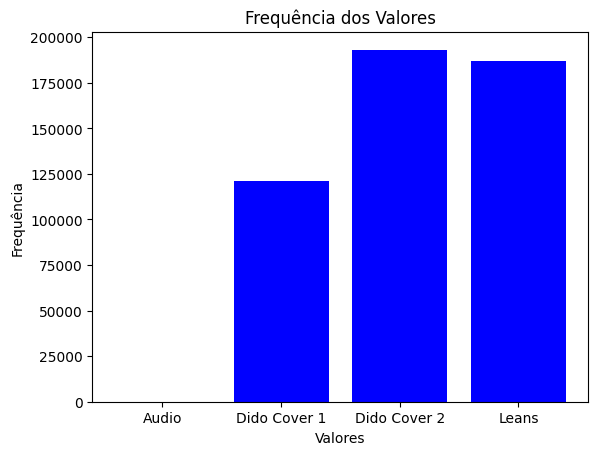

[0, 120895, 193164, 187092]

In [10]:
etl('./musics/dido.m4a', 'predict', 0)